In [2]:
import json
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns

In [3]:
# Constants
sr = 125
TOTAL_SAMPLES = 30 * sr

NUM_SLICES = 10  # Define the number of slices (segments) per EEG signal.
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES) # Number of samples per slice, based on your requirement (e.g., 125 samples).

In [4]:
def preprocess_data_MFCC(source_json_path, output_json_path):
    # Dictionary to store labels and processed data
    mydict = {
        "labels": [],
        "mfcc": []
    }

    # Open the source JSON file and load the data
    with open(source_json_path, 'r') as f:
        data = json.load(f)

    # Browse each subject and their EEG signals
    for subject in data['subjects']:
        for song in subject['view_songs']:
            if song["class"]!= 'no_stimuli':
                    if np.array(song['EEG_signal']).shape[0]==3750:
                        eeg_signal = np.array(song['EEG_signal'])  # Convert the EEG signal to a numpy array
                        label = song['class']  # The class label for this EEG signal
                        Mfcc=[]
                        for i in range(eeg_signal.shape[1]):
                            #MFcc=[]
                            electrode = eeg_signal[:, i]
                            # Slice the EEG signal into segments
                            #for s in range(NUM_SLICES):
                            #    start_sample = SAMPLES_PER_SLICE * s
                            #    end_sample = start_sample + SAMPLES_PER_SLICE

                            #    slice_eeg = electrode[start_sample:end_sample]  # Slice for EEG data (channels x time)
                            flattened_signal = electrode.flatten()

                                # Compute MFCC
                                # Flatten the EEG data (concatenate all channels together for MFCC computation)
                            mfcc = librosa.feature.mfcc(y=flattened_signal, sr=sr, n_mfcc=128,n_fft=256,hop_length=30)
                            mfcc = mfcc.T  # Transpose to have time along rows and MFCC features along columns

                            mfcc = mfcc[:125, :]
                                
                            #MFcc.append(mfcc.tolist())
                            Mfcc.append(mfcc.tolist())
                        # Append the label and MFCC to the dictionary
                        mydict["labels"].append(label)
                        mydict["mfcc"].append(Mfcc)  # Convert MFCC to list for saving to JSON

    # Save the processed data to the output JSON file
    with open(output_json_path, 'w') as f:
        json.dump(mydict, f)

def load_data_MFCC(json_path):
    # Load the JSON data from the file
    with open(json_path, 'r') as f:
        data = json.load(f)

    x = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return x, y

In [5]:
def preprocess_data_STFT(source_json_path, output_json_path):
    # Dictionary to store labels and processed data
    mydict = {
        "labels": [],
        "stft": []
    }

    # Open the source JSON file and load the data
    with open(source_json_path, 'r') as f:
        data = json.load(f)

    # Browse each subject and their EEG signals
    for subject in data['subjects']:
        for song in subject['view_songs']:
            if song["class"]!= 'no_stimuli':
                    if np.array(song['EEG_signal']).shape[0]==3750:
                        eeg_signal = np.array(song['EEG_signal'])  # Convert the EEG signal to a numpy array
                        label = song['class']  # The class label for this EEG signal
                        Stft=[]
                        for i in range(eeg_signal.shape[1]):
                            #MFcc=[]
                            electrode = eeg_signal[:, i]
                            # Slice the EEG signal into segments
                            #for s in range(NUM_SLICES):
                            #    start_sample = SAMPLES_PER_SLICE * s
                            #    end_sample = start_sample + SAMPLES_PER_SLICE

                            #    slice_eeg = electrode[start_sample:end_sample]  # Slice for EEG data (channels x time)
                            flattened_signal = electrode.flatten()

                            stft = np.abs(librosa.stft(flattened_signal,n_fft=256,hop_length=30))
                            stft = stft.T

                            stft = stft[:125, :]
                                
                            Stft.append(stft.tolist())
                        # Append the label and MFCC to the dictionary
                        mydict["labels"].append(label)
                        mydict["stft"].append(Stft)  # Convert MFCC to list for saving to JSON

    # Save the processed data to the output JSON file
    with open(output_json_path, 'w') as f:
        json.dump(mydict, f)

def load_data_STFT(json_path):
    # Load the JSON data from the file
    with open(json_path, 'r') as f:
        data = json.load(f)

    x = np.array(data["stft"])
    y = np.array(data["labels"])

    return x, y

In [6]:
if not os.path.exists("eeg_mfcc.json"):
    preprocess_data_MFCC("SynapSound_data.json","eeg_mfcc.json")
else:
    print("File already exists, skipping preprocessing.")

In [7]:
if not os.path.exists("eeg_stft.json"):
    preprocess_data_STFT("SynapSound_data.json","eeg_stft.json")
else:
    print("File already exists, skipping preprocessing.")

In [8]:
inputs_MFCC, targets_MFCC =load_data_MFCC("eeg_mfcc.json")

In [9]:
inputs_MFCC.shape

(239, 16, 125, 128)

In [10]:
inputs_STFT, targets_STFT= load_data_STFT(json_path="eeg_stft.json")

In [11]:
inputs_STFT.shape

(239, 16, 125, 129)

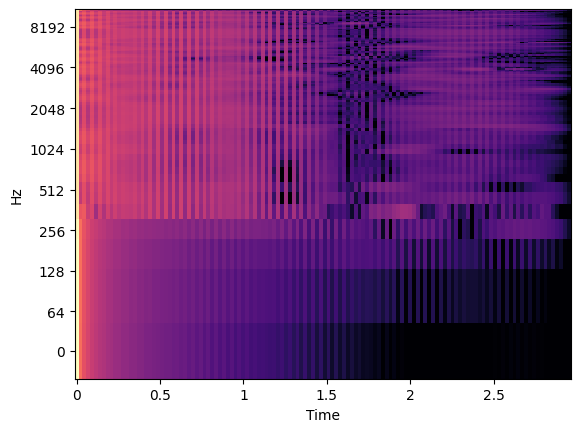

In [12]:
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(inputs_MFCC[0][0],ref=np.max),y_axis="log",x_axis="time",ax=ax)

In [13]:
# Load the model from the file
with open('CNN14.pkl', 'rb') as file_new:
    model_new = pickle.load(file_new)

2025-09-21 20:08:52.310686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1758506933.473176   32113 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 888 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [14]:
genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "metal",
        3 : "pop",
        }
inv_genre_dict = {
    'blues': 0,
    'classical': 1,
    'metal': 2,
    'pop': 3
}

In [15]:
from collections import Counter

In [16]:
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score

predicted_classes = []
actual_classes = []

for song_idx in range(239):

    class_count = Counter()

    for i in range(0, 16):
        mfcc = np.expand_dims(inputs_MFCC[song_idx][i], axis=-1)
        mfcc = np.expand_dims(mfcc, axis=0)

        stft = np.expand_dims(inputs_STFT[song_idx][i], axis=-1)
        stft = np.expand_dims(stft, axis=0)

        prediction = model_new.predict([mfcc, stft])
        predicted_class = np.argmax(prediction, axis=1)[0]

        # Update the count for the predicted class
        class_count[predicted_class] += 1

    most_common_class, _ = class_count.most_common(1)[0]
    predicted_classes.append(most_common_class)

    actual_class = inv_genre_dict[targets_MFCC[song_idx]]
    actual_classes.append(actual_class)


2025-09-21 20:08:54.138675: I external/local_xla/xla/service/service.cc:163] XLA service 0x7de378002980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-21 20:08:54.138691: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-09-21 20:08:54.144665: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-21 20:08:54.171473: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


I0000 00:00:1758506934.535769   32671 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [17]:
conf_matrix = confusion_matrix(actual_classes, predicted_classes)
accuracy = accuracy_score(actual_classes, predicted_classes)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[ 0  0 59  0]
 [ 0  0 60  0]
 [ 0  0 60  0]
 [ 0  0 60  0]]
Accuracy: 0.2510


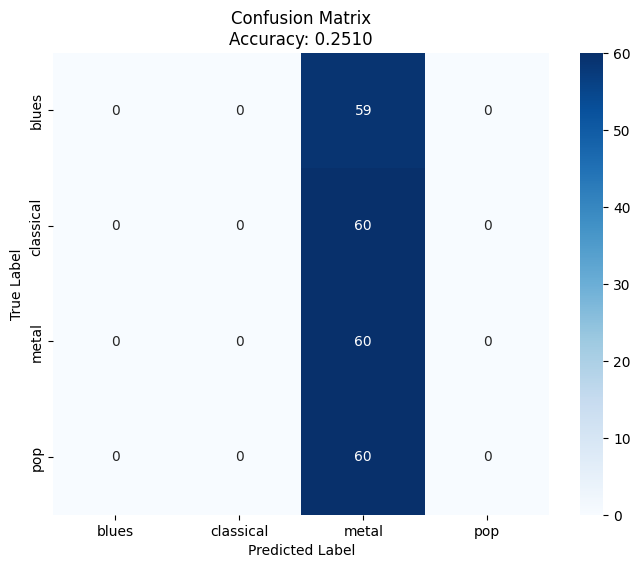

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=inv_genre_dict.keys(), yticklabels=inv_genre_dict.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.4f}')
plt.show()